In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
from torch import nn
import torch.nn.functional as F

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

from tqdm.notebook import tqdm

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

### Network Definition

In [60]:
# difficulty 分情况 w=0/1
class DiffNet(nn.Module):
    def __init__(self, feature_num, user_num, length, leveldiff_dim=0, challenge_dim=1, win_dim=2, 
                 diff_level=5,device="cpu",
                fix_params=False, params=[]):
        super().__init__()
        beta = torch.randn((feature_num-3+2*diff_level, length))
        self.beta = nn.Parameter(beta)
        if fix_params:
            self.alpha = torch.tensor(params[0]).unsqueeze(1) # alpha, user_num*1
            self.gamma = torch.tensor(params[1]).unsqueeze(1) # gamma, user_num*1
            if device != "cpu":
                self.alpha = self.alpha.cuda()
                self.gamma = self.gamma.cuda()
        else:
            alpha = torch.rand((user_num,1))
            gamma = torch.randn((user_num,1))
            self.alpha = nn.Parameter(alpha)
            self.gamma = nn.Parameter(gamma)
        
        self.leveldiff_dim = leveldiff_dim
        self.challenge_dim = challenge_dim
        self.win_dim = win_dim
        self.diff_level = diff_level
        
        self.feature_num = feature_num
        self.user_num = user_num
        self.length = length
        self.device = device
    
    def forward(self, x_input, uid, t):
        # x_input: batch_size * feature_num * length
        # uid: batch_size * user_num
        
        #u_alpha = torch.mm(uid, torch.clamp(self.alpha.abs(),0,1)).sum(dim=1) # u_alpha: batch_size*1
        #u_gamma = torch.mm(uid, torch.clamp(self.gamma,-1,1)).sum(dim=1).unsqueeze(1).repeat(1,self.length) # u_gamma: batch_size*length
        
        u_alpha = torch.mm(uid, self.alpha.abs()).sum(dim=1) # u_alpha: batch_size*1
        u_gamma = torch.mm(uid, self.gamma).sum(dim=1).unsqueeze(1).repeat(1,self.length) # u_gamma: batch_size*length
        
        x_diff = (x_input[:,self.challenge_dim,:]-torch.mul(x_input[:,self.leveldiff_dim,:],u_alpha.unsqueeze(1))-u_gamma) # x_diff: batch_size*length
        
        level_diff = self.calculate_diff(x_diff, x_input[:,self.win_dim,:]) # batch_size * (diff_level*2) * length
        
        feature_idx = [i for i in range(feature_num) if 
                       i not in [self.leveldiff_dim,self.challenge_dim,self.win_dim]]
        x_input_diff = torch.cat((x_input[:,feature_idx,:],level_diff),dim=1) # batch_size*feature*length
        
        y = self.time_mul(x_input_diff,t)  # y: batch_size * 1
        return y # y: batch_size *1
    
    def time_mul(self, x_input, t):
        # x_input: batch_size * feature * length
        # t: batch_size * 1
        x_beta = (x_input*self.beta).sum(dim=1) # batch_size*length
        y = torch.gather(x_beta,dim=1,index=t.long()-1)#.unsqueeze(1)
        
        return y
    
    def predict(self, x_input, uid, t):
        return self.forward(x_input, uid, t)
    
    def one_hot(self, label):
        batch_size = label.shape[0]
        length = label.shape[1]
        label = label.resize_(batch_size, 1, length)
        if self.device=='cpu':
            m_zeros = torch.zeros(batch_size,  2*self.diff_level+1, length)
        else:
            m_zeros = torch.zeros(batch_size,  2*self.diff_level+1, length).cuda()
        onehot = m_zeros.scatter_(1, label, 1)[:,:-1]  # (dim,index,value)
        
        return onehot  # Tensor -> Numpy
    
    def calculate_diff(self, x, win):
        # x: batch_size*length
        # win: batch_size*length
        Min, Max = x.min(), x.max()
        #Min,Max = -2,2
        
        x_rescale = (x-Min+win*(Max-Min))/(Max-Min)*self.diff_level
        x_level = self.one_hot(x_rescale.floor().long()) # x_level: batch_size * diff_level * length
        
        return x_level  #batch_size* diff_level * length

### Dataset Construction

In [4]:
# load data
original_data = pd.read_csv("../data/Data_process/Cox_feature_interaction_part_last.csv")
original_data["win"] = original_data["last_win"].shift(-1)
original_data.fillna(0,inplace=True)

In [5]:
# select part of the dataset
print("original data size: ",original_data.shape)
all_data = original_data.loc[original_data.user_id<=1000]
print("select 1000 users, size: ",all_data.shape)

original data size:  (2244582, 22)
select 1000 users, size:  (1108991, 22)


In [6]:
# observe the session_length
print("Distribution of session length:")
pd.cut(all_data.groupby(["user_id","session_id"]).session_length.max(),bins=5).value_counts(normalize=True)

Distribution of session length:


(4.514, 102.2]    0.981982
(102.2, 199.4]    0.016410
(199.4, 296.6]    0.001368
(296.6, 393.8]    0.000222
(393.8, 491.0]    0.000018
Name: session_length, dtype: float64

In [7]:
# set max length of session (more, censored)
max_length = 160

In [8]:
# length clamp
all_data = all_data.loc[all_data.session_depth<max_length]
all_data["event"] = all_data["session_length"].apply(lambda x: x<=max_length)
all_data["cut_length"] = all_data["session_length"].apply(lambda x: min(x,max_length))

In [9]:
# select features, user list
feature_name = ["game_weekday","hour","session_id","day_session","last_item","last_win","last_duration","last_energy",
                "session_depth","avg_item","avg_duration","avg_passrate",
                "last_oneday","last_3day","last_oneweek","last_one","global_retrytime","retry_time","win"]
                #"global_passrate","pass_rate"]
feature_dict = dict(zip(feature_name,range(len(feature_name))))
features = all_data.loc[:,feature_name]
uid_list = all_data.loc[:,"user_id"].to_numpy()

In [11]:
# 根据session划分数据集：每个用户随机sample 1/10为test set，1/10为validation set
import random

def generate_dict(name):
    dict_t = {}
    cnt = 0
    for uid in session_dict_list[name]:
        dict_t[uid] = {}
        for sid in session_dict_list[name][uid]:
            dict_t[uid][sid] = cnt
            cnt += 1
    return dict_t

random.seed(2020)
# session_list: pandas, 每一行表示一个用户，记录三个数据集对应的session id
session_list = all_data.groupby(["user_id"]).session_id.apply(lambda x:(sorted(list(set(x))))).reset_index().rename(columns={"session_id":"session_list"})
session_list["session_num"] = session_list["session_list"].apply(lambda x: len(x))
session_list["session_list"].apply(lambda x:random.shuffle(x))
session_list["train_list"] = session_list.apply(lambda x: x["session_list"][:int(x["session_num"]*0.8)],axis=1)
session_list["val_list"] = session_list.apply(lambda x: x["session_list"][int(x["session_num"]*0.8):int(x["session_num"]*0.9)],axis=1)
session_list["test_list"] = session_list.apply(lambda x: x["session_list"][int(x["session_num"]*0.9):],axis=1)
# session_dict_list: dict，第一层key表示数据集，第二层key为user id，value为session id的list
session_ulist = session_list.user_id.tolist()
session_dict_list = {}
for col in session_list.columns:
    if "list" in col and "session" not in col:
        session_dict_list[col] = dict(zip(session_ulist,session_list[col].tolist()))

# 对三个数据集下的session重新从0开始编号（方便生成session为基础的矩阵）
dict_train = generate_dict("train_list")
dict_val = generate_dict("val_list")
dict_test = generate_dict("test_list")

# all_data中每一行，划分到train、val、test，记录对应的idx和session re-id
train_idx,test_idx,val_idx = [],[],[]
train_sidx, test_sidx, val_sidx = [],[],[]
for i,(uid, sid) in enumerate(zip(all_data.user_id.tolist(),all_data.session_id.tolist())):
    if sid in session_dict_list["train_list"][uid]:
        train_idx.append(i)
        train_sidx.append(dict_train[uid][sid])
    elif sid in session_dict_list["val_list"][uid]:
        val_idx.append(i)
        val_sidx.append(dict_val[uid][sid])
    elif sid in session_dict_list["test_list"][uid]:
        test_idx.append(i)
        test_sidx.append(dict_test[uid][sid])
    else:
        print(uid,sid)
        break

In [12]:
# 拟合Difficulty曲线
def plot_linear(x,y, a,b, uid=0,savefig=False,filename=""):
    # scatter original data, plot the linear ax+b
    plt.figure(figsize=(10,5))
    ax = plt.subplot()
    ax.scatter(x,y,s=2)
    ax.plot(x,a*x+b,color='r')
    ax.set_xlabel("level difficulty (global retry time)",fontsize=16)
    ax.set_ylabel("user's retry time",fontsize=16)
    ax.set_title("User %d"%(uid),fontsize=18)
    if savefig:
        plt.savefig("figures/"+filename)
    plt.show()

# get retry data from training set
train_df = all_data.iloc[train_idx, :]
retry_data = train_df.loc[train_df.win==1].groupby(["user_id","level_id"]).head(1)
retry_data = retry_data.loc[:,["user_id","global_retrytime","retry_time"]]
retry_dedup = retry_data.groupby(["user_id","global_retrytime"]).agg({"retry_time":"mean"}).reset_index()

# fit the curve
Neighbor = 5
uidlist, alist, blist, selist,lenlist, selist_all = [],[],[],[],[],[]
for uid in tqdm(set(retry_dedup.user_id.tolist())):
    uidlist.append(uid)
    x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
    y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
    y_cum = y.cumsum()
    y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])

    A = np.vstack([x,np.ones(len(x))]).T
    results = np.linalg.lstsq(A,y_smooth, rcond=None)
    alist.append(results[0][0])
    blist.append(results[0][1])
    selist.append(results[1][0]/len(x))
    selist_all.append(results[1][0])
    lenlist.append(len(x))
fit_results = pd.DataFrame(np.array([uidlist, alist, blist, selist,lenlist,selist_all]).T,
                           columns=["user_id","a","b","s_e","length","s_e_all"])

In [13]:
top_fit = fit_results.sort_values(by="s_e").head(20)
worst_fit = fit_results.sort_values(by="s_e").tail(20)

In [14]:
# for row in top_fit.iterrows():
#     print("user id: %d, a: %.2f, b:%.2f, length: %d"%(row[1].user_id,row[1].a,row[1].b,row[1].length))
#     uid = row[1].user_id
#     x = retry_dedup.loc[retry_dedup.user_id==uid].global_retrytime.to_numpy()
#     y = retry_dedup.loc[retry_dedup.user_id==uid].retry_time.to_numpy()
#     y_cum = y.cumsum()
#     y_smooth = np.array([(y_cum[min(i+Neighbor,len(y)-1)]-y_cum[max(i-Neighbor,0)])/(2*Neighbor+1) for i in range(len(y))])

#     plot_linear(x,y_smooth,row[1].a,row[1].b,uid)

In [22]:
y_depth = all_data.session_depth.to_numpy()
train_dict = dict(zip(train_idx,train_sidx))
val_dict = dict(zip(val_idx,val_sidx))
test_dict = dict(zip((test_idx),test_sidx))
uid_nodup = list(set(uid_list)) # uid 去重
uid_dict = dict(zip(uid_nodup,range(len(set(uid_list)))))

In [27]:
# 得到user对应a、b拟合结果
user_alpha = dict(zip(fit_results.user_id.tolist(),fit_results.a.tolist()))
user_gamma = dict(zip(fit_results.user_id.tolist(),fit_results.b.tolist()))
alpha_list = [user_alpha.get(uid,0) for uid in uid_nodup]
gamma_list = [user_gamma.get(uid,0) for uid in uid_nodup]

In [31]:
# standardize
cols_standardize = ["session_id","day_session","last_item","last_win","last_duration","session_depth","avg_item","avg_duration","last_oneday","last_3day","last_oneweek","last_one"]
cols_leave = ["avg_passrate","win","global_retrytime","retry_time"]
cols_minmax = ["game_weekday","hour","last_energy"]#,"global_retrytime","retry_time"]

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
minmax = [([col],MinMaxScaler()) for col in cols_minmax]

x_mapper = DataFrameMapper(standardize + leave+minmax)

features_np = features.to_numpy()
features_np[train_idx,:] = x_mapper.fit_transform(features.iloc[train_idx,:]).astype('float32')
features_np[val_idx,:] = x_mapper.transform(features.iloc[val_idx,:]).astype('float32')
features_np[test_idx,:] = x_mapper.transform(features.iloc[test_idx,:]).astype('float32')

In [33]:
events = all_data.event.tolist()

In [34]:
# 三个数据集的sample
x_itrain = np.zeros((len(set(train_dict.values())),len(feature_name),max_length))
x_ival = np.zeros((len(set(val_dict.values())),len(feature_name),max_length))
x_itest = np.zeros((len(set(test_dict.values())),len(feature_name),max_length))
# 三个数据集的每个样本对应的user id
x_utrain = torch.zeros((len(set(train_dict.values())),len(uid_dict)))
x_uval = torch.zeros((len(set(val_dict.values())),len(uid_dict)))
x_utest = torch.zeros((len(set(test_dict.values())),len(uid_dict)))
# 三个数据集的label
y_train_length, y_train_event = np.zeros((len(set(train_dict.values())))), np.zeros((len(set(train_dict.values()))))
y_test_length, y_test_event = np.zeros((len(set(test_dict.values())))), np.zeros((len(set(test_dict.values()))))
y_val_length, y_val_event = np.zeros((len(set(val_dict.values())))), np.zeros((len(set(val_dict.values()))))
for i in tqdm(range(len(y_depth))):
    if i in train_dict:
        x_itrain[train_dict[i],:,y_depth[i]] = features_np[i,:]
        x_utrain[train_dict[i],uid_dict[uid_list[i]]] = 1
        y_train_length[train_dict[i]] = max(y_train_length[train_dict[i]],y_depth[i]+1)
        y_train_event[train_dict[i]] = events[i]
        
    elif i in val_dict:
        x_ival[val_dict[i],:,y_depth[i]] = features_np[i,:]
        x_uval[val_dict[i],uid_dict[uid_list[i]]] = 1
        y_val_length[val_dict[i]] = max(y_val_length[val_dict[i]],y_depth[i]+1)
        y_val_event[val_dict[i]] = events[i]
        
    elif i in test_dict:
        x_itest[test_dict[i],:,y_depth[i]] = features_np[i,:]
        x_utest[test_dict[i],uid_dict[uid_list[i]]] = 1
        y_test_length[test_dict[i]] = max(y_test_length[test_dict[i]],y_depth[i]+1)
        y_test_event[test_dict[i]] = events[i]
        
    else:
        print(i)
        break

In [38]:
def generate_data(x,uid,y_l,y_c):
    return (torch.FloatTensor(x), uid), (y_l,y_c)

x_train,y_train = generate_data(x_itrain,x_utrain,y_train_length,y_train_event)
x_val,y_val = generate_data(x_ival,x_uval,y_val_length,y_val_event)
x_test,y_test = generate_data(x_itest,x_utest,y_test_length,y_test_event)

In [39]:
durations_test, events_test = y_test

In [40]:
y_train = (torch.tensor(y_train[0]),torch.tensor(y_train[1]))
y_val = (torch.tensor(y_val[0]),torch.tensor(y_val[1]))
val_data = tt.tuplefy(x_val, y_val)

###  Model definition

In [57]:
feature_num,length = x_itrain.shape[1], x_itrain.shape[2]
user_num = len(set(uid_list))
device="cuda"
#device="cpu"
diff_level=5 # difficulty to n levels
print("feature number: %d, length: %d, user number: %d, difficulty level: %d"%(feature_num,length,user_num,diff_level))
print("device: %s"%(device))

feature number: 19, length: 160, user number: 944, difficulty level: 5
device: cuda


In [42]:
# 不fix params
# np.random.seed(1234)
# _ = torch.manual_seed(123)
# diffnet = DiffNet(feature_num, user_num, length,leveldiff_dim = feature_dict["global_retrytime"],
#                   challenge_dim=feature_dict["retry_time"],win_dim=feature_dict["win"],diff_level=diff_level,device=device)
# model = CoxTime(diffnet, tt.optim.Adam,device=device)#labtrans=labtrans)

In [73]:
# fix params
np.random.seed(1234)
_ = torch.manual_seed(123)

diffnet = DiffNet(feature_num, user_num, length,leveldiff_dim = feature_dict["global_retrytime"],
                  challenge_dim=feature_dict["retry_time"],win_dim=feature_dict["win"],
                  diff_level=diff_level,device=device,
                 fix_params=True, params=[alpha_list,gamma_list])
model = CoxTime(diffnet, tt.optim.Adam,device=device)#labtrans=labtrans)

### Model Training

In [66]:
# test
if device=="cuda":
    uid = x_train[1][:1000].cuda()
    x_input = x_train[0][:1000].cuda()
    y_t = y_train[0][:1000].unsqueeze(1).cuda()
else:
    uid = x_train[1][:1000]
    x_input = x_train[0][:1000]
    y_t = y_train[0][:1000].unsqueeze(1)
y = model.net.forward(x_input,uid,y_t)

best lr:  0.15556761439304817


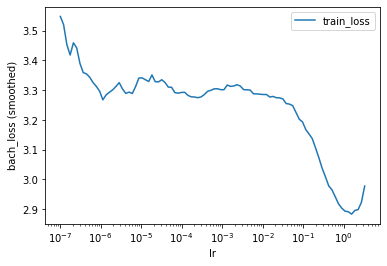

In [68]:
# lr find
batch_size = 512
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=5)
_ = lrfinder.plot()
print("best lr: ",lrfinder.get_best_lr())

In [ ]:
%%time
# for batch_size in [512,1024,2048,4096]:
#      for lr in [0.2,0.1,0.05,0.02,0.01,0.001]:
#for lr in [0.01]:
#lr = 0.01
lr = 0.02
batch_size=512
print("learning rate: ",lr)
print("bach_size: ",batch_size)
np.random.seed(1234)
_ = torch.manual_seed(123)

# diffnet = DiffNet(feature_num, user_num, length,leveldiff_dim = feature_dict["global_retrytime"],
#               challenge_dim=feature_dict["retry_time"],win_dim=feature_dict["win"],diff_level=diff_level,device=device)
diffnet = DiffNet(feature_num, user_num, length,leveldiff_dim = feature_dict["global_retrytime"],
                  challenge_dim=feature_dict["retry_time"],win_dim=feature_dict["win"],
                  diff_level=diff_level,device=device,
                 fix_params=True, params=[alpha_list,gamma_list])

model = CoxTime(diffnet, tt.optim.Adam,device=device)#labtrans=labtrans)

epochs=256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

model.optimizer.set_lr(lr)
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
            val_data=val_data)

baseline_hazards = model.compute_baseline_hazards()
surv = model.predict_surv(x_test)
surv_df = pd.DataFrame(surv.numpy().T)
ev = EvalSurv(surv_df, durations_test, events_test, censor_surv='km')
c_index = ev.concordance_td("antolini")
print("C INDEX: ",c_index)

learning rate:  0.02
bach_size:  512
0:	[3s / 3s],		train_loss: 2.1235,	val_loss: 1.2881
1:	[3s / 6s],		train_loss: 1.0418,	val_loss: 0.8716
2:	[3s / 10s],		train_loss: 0.7971,	val_loss: 0.7559
3:	[2s / 13s],		train_loss: 0.7043,	val_loss: 0.7071
4:	[3s / 16s],		train_loss: 0.6690,	val_loss: 0.6865
5:	[3s / 19s],		train_loss: 0.6539,	val_loss: 0.6821
6:	[2s / 22s],		train_loss: 0.6471,	val_loss: 0.6890
7:	[3s / 25s],		train_loss: 0.6405,	val_loss: 0.6537
8:	[3s / 28s],		train_loss: 0.6323,	val_loss: 0.6603
9:	[2s / 31s],		train_loss: 0.6299,	val_loss: 0.6652
10:	[3s / 35s],		train_loss: 0.6330,	val_loss: 0.6687
11:	[3s / 38s],		train_loss: 0.6303,	val_loss: 0.6640
12:	[3s / 41s],		train_loss: 0.6300,	val_loss: 0.6574
13:	[3s / 44s],		train_loss: 0.6267,	val_loss: 0.6608
14:	[3s / 47s],		train_loss: 0.6312,	val_loss: 0.6623
15:	[3s / 50s],		train_loss: 0.6299,	val_loss: 0.6679
16:	[3s / 54s],		train_loss: 0.6262,	val_loss: 0.6667
17:	[3s / 57s],		train_loss: 0.6244,	val_loss: 0.6650


In [135]:
%%time
# for batch_size in [512,1024,2048,4096]:
#      for lr in [0.2,0.1,0.05,0.02,0.01,0.001]:
#for lr in [0.01]:
#lr = 0.01

# 不对alpha和gamma做限制，min、max由x决定

lr = 0.02
batch_size=512
print("learning rate: ",lr)
print("bach_size: ",batch_size)
np.random.seed(1234)
_ = torch.manual_seed(123)

diffnet = DiffNet(feature_num, user_num, length,leveldiff_dim = feature_dict["global_retrytime"],
              challenge_dim=feature_dict["retry_time"],win_dim=feature_dict["win"],diff_level=diff_level,device=device)
model = CoxTime(diffnet, tt.optim.Adam,device=device)#labtrans=labtrans)

epochs=256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

model.optimizer.set_lr(lr)
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
            val_data=val_data)

baseline_hazards = model.compute_baseline_hazards()
surv = model.predict_surv(x_test)
surv_df = pd.DataFrame(surv.numpy().T)
ev = EvalSurv(surv_df, durations_test, events_test, censor_surv='km')
c_index = ev.concordance_td("antolini")
print("C INDEX: ",c_index)

learning rate:  0.02
bach_size:  512
0:	[30s / 30s],		train_loss: 1.2741,	val_loss: 0.9340
1:	[25s / 55s],		train_loss: 0.8098,	val_loss: 0.7514
2:	[13s / 1m:9s],		train_loss: 0.7039,	val_loss: 0.6982
3:	[10s / 1m:19s],		train_loss: 0.6728,	val_loss: 0.6856
4:	[8s / 1m:28s],		train_loss: 0.6566,	val_loss: 0.6818
5:	[8s / 1m:36s],		train_loss: 0.6507,	val_loss: 0.6753
6:	[7s / 1m:43s],		train_loss: 0.6450,	val_loss: 0.6686
7:	[7s / 1m:51s],		train_loss: 0.6400,	val_loss: 0.6514
8:	[7s / 1m:58s],		train_loss: 0.6383,	val_loss: 0.6664
9:	[5s / 2m:4s],		train_loss: 0.6378,	val_loss: 0.6706
10:	[5s / 2m:9s],		train_loss: 0.6338,	val_loss: 0.6680
11:	[5s / 2m:15s],		train_loss: 0.6378,	val_loss: 0.6595
12:	[5s / 2m:20s],		train_loss: 0.6326,	val_loss: 0.6565
13:	[4s / 2m:25s],		train_loss: 0.6323,	val_loss: 0.6623
14:	[4s / 2m:30s],		train_loss: 0.6341,	val_loss: 0.6659
15:	[4s / 2m:35s],		train_loss: 0.6347,	val_loss: 0.6722
16:	[5s / 2m:40s],		train_loss: 0.6344,	val_loss: 0.6705
17:	[5s /

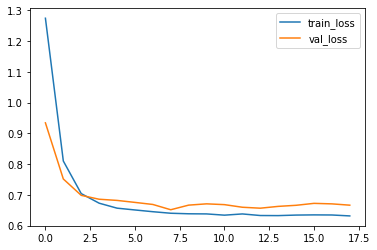

In [148]:
_ = log.plot()

In [149]:
# 不预训练
log.to_pandas().val_loss.min()

0.6514222025871277

In [70]:
# 预训练
log.to_pandas().val_loss.min()

0.6602799296379089

----
## Prediction

In [150]:
model.net.alpha.min(),model.net.alpha.max()

(tensor(0.0005, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.9979, device='cuda:0', grad_fn=<MaxBackward1>))

In [151]:
model.net.gamma.min(),model.net.gamma.max()

(tensor(-2.8600, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(3.2976, device='cuda:0', grad_fn=<MaxBackward1>))

In [152]:
baseline_hazards.shape

(156,)

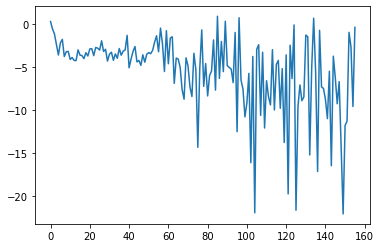

In [153]:
# 不预训练
plt.plot(np.arange(baseline_hazards.shape[0]),np.log(baseline_hazards.values))

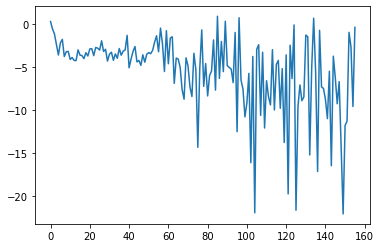

In [153]:
# 做预训练
plt.plot(np.arange(baseline_hazards.shape[0]),np.log(baseline_hazards.values))

In [154]:
surv = model.predict_surv(x_test)
surv_train = model.predict_surv((x_train[0],x_train[1]))

In [156]:
surv.shape

torch.Size([5839, 156])

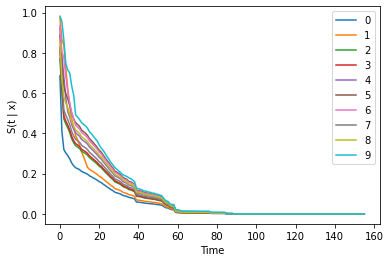

In [157]:
pd.DataFrame(surv.numpy().T).iloc[:,0:10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [158]:
durations_test[0:10]

array([ 5., 19.,  6.,  6.,  9.,  7., 13.,  6.,  7., 13.])

----
## Evaluation

In [155]:
# 不做预训练
surv_df = pd.DataFrame(surv.numpy().T)
ev = EvalSurv(surv_df, durations_test, events_test, censor_surv='km')
print("C-index")ev.concordance_td("antolini")

0.7421107983583098

In [159]:
surv_df_train = pd.DataFrame(surv_train.numpy().T)
ev_train = EvalSurv(surv_df_train,y_train[0].numpy(),y_train[1].numpy())#,censor_surv='km')
ev_train.concordance_td("antolini")

0.737776634406396

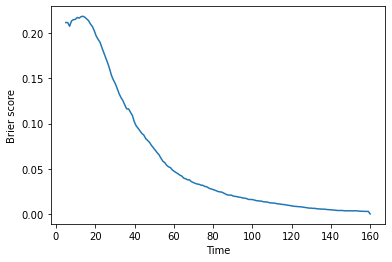

In [160]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 161)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [161]:
# IBS
ev.brier_score(time_grid).mean()

0.059494172609931666

-----
## Survival to churn prediction

In [162]:
alpha = abs(model.net.alpha.cpu().detach().numpy())

In [163]:
beta = (model.net.beta.cpu().detach().numpy())

In [164]:
gamma = model.net.gamma.cpu().detach().numpy()

In [165]:
h0 = baseline_hazards.values.tolist()

In [166]:
all_features = features_np
all_uid = all_data["user_id"].to_numpy()

In [171]:
m = []
cnt = 0
select_featuredim = [feature_dict[key] for key in feature_dict if key not in ["retry_time",
                                                                          "global_retrytime","win"]]
diff_list = []
for feature,uid in (zip(all_features,all_uid)):
    #print(feature,uid)
    if cnt%100000==0:
        print(cnt)
    cnt += 1
    diff = feature[feature_dict["retry_time"]]-alpha[uid_dict[uid]] \
            *feature[feature_dict["global_retrytime"]]- gamma[uid_dict[uid]]
    diff_list.append(diff)

Min, Max = min(diff_list),max(diff_list)
for feature,uid, diff in zip(all_features,all_uid,diff_list):
    if cnt%100000==0:
        print(cnt)
    cnt += 1
    win = feature[feature_dict["win"]]
    scale_diff = (diff-Min+win*(Max-Min))/(Max-Min)*diff_level
    
    t = int(feature[feature_dict["session_depth"]])
    beta_this = beta[:,t]
    if scale_diff == diff_level*2:
        beta_diff = 0
    else:
        beta_diff = beta[feature_num-3+int(scale_diff),t]
    m.append((beta_this[select_featuredim]*feature[select_featuredim]).sum()+beta_diff)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000


In [172]:
all_data["g_x"] = m

In [173]:
all_data["h_t"] = all_data.apply(lambda x: np.exp(x.g_x)*h0[max(x.session_depth-4,0)],axis=1)

In [174]:
# 对每条数据，计算H(t|x): 当前session到目前的h之和，计算S(t|x)= exp(-H(t|x))
uids, sids, hts = all_data.user_id.tolist(), all_data.session_id.tolist(), all_data.h_t.tolist()
depths = all_data.session_depth.tolist()
H_t = [hts[0]]
labels = []
for i in range(1,len(uids)):
    if uids[i] == uids[i-1] and sids[i]==sids[i-1] and depths[i]>=5:
        H_t.append(H_t[i-1] + hts[i])
        labels.append(False)
    else:
        H_t.append(hts[i])
        labels.append(True)
all_data["H_t"] = H_t
labels.append(True)
all_data["S_t"] = np.exp(-all_data["H_t"])

In [175]:
#标注true label（是否离开）
all_data["label"] = labels

In [176]:
# 计算AUC、ACC
from sklearn.metrics import roc_auc_score

# test
y_pred = all_data.iloc[test_idx,:].loc[(all_data.session_id!=0)&(all_data.session_depth>3)&(all_data.event==True)].S_t.tolist()
y_label = all_data.iloc[test_idx,:].loc[(all_data.session_id!=0)&(all_data.session_depth>3)&(all_data.event==True)].label.tolist()
print("test auc: ",roc_auc_score(y_label, y_pred))

y_pred = all_data.iloc[train_idx,:].loc[(all_data.session_id!=0)&(all_data.session_depth>3)&(all_data.event==True)].S_t.tolist()
y_label = all_data.iloc[train_idx,:].loc[(all_data.session_id!=0)&(all_data.session_depth>3)&(all_data.event==True)].label.tolist()
print("train auc: ",roc_auc_score(y_label, y_pred))

test auc:  0.596956694020871
train auc:  0.6036709329384546


## Parameters analysis

In [ ]:
# 对alpha进行分析：
# 1. 用户平均user_diff/global_diff，与alpha的关系 （散点图）
# 2. 取top50中的10个用户和bottom50中的10个用户，随机选择一个session，看随session长度变化，用户 diff/global diff 的差异
# 


Text(0, 0.5, 'user histogram')

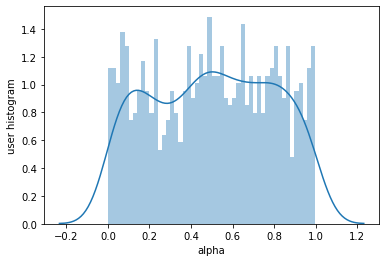

In [118]:
import seaborn as sns
plt.figure()
sns.distplot(alpha,bins=50)
plt.xlabel("alpha")
plt.ylabel("user histogram")

/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  


[-0.21446282, -0.05072999, -0.04452675, -0.06850295, -0.10768643]

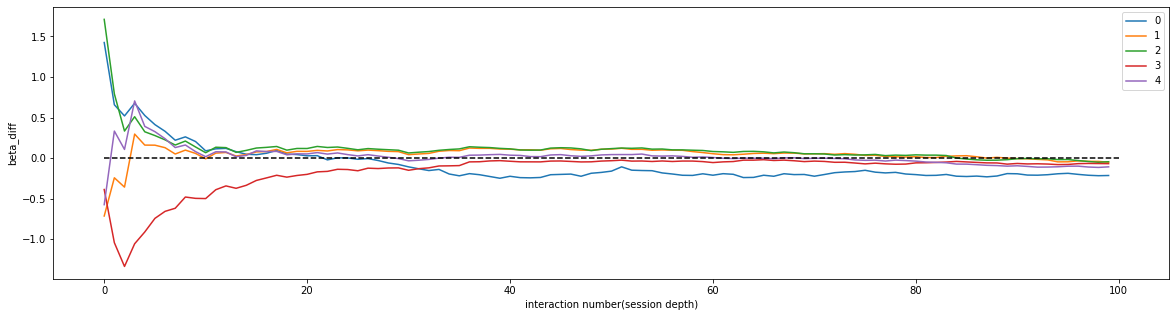

In [133]:
# 对beta进行分析：
# beta_diff 在不同时刻的变化plot: win=0
plt.figure(figsize=(20,diff_level))
ax = plt.subplot()
plots = []
Mean = []
for i in range(0,diff_level):
    plots.append(ax.plot(beta[feature_num-3+i,:100].cumsum()/np.arange(1,101)))
    Mean.append(beta[feature_num-3+i,:100].mean())


#labels = ["[0.6,1)","[-0.2,0.2)","(-1,-0.6]"]
labels = np.arange(0,diff_level)
plt.legend(plots,labels=labels)
ax.plot([0,100],[0,0],"--k")
ax.set_xlabel("interaction number(session depth)")
ax.set_ylabel("beta_diff")
Mean

In [130]:
a = np.array([1,2,3,4])
a.cumsum()/np.arange(1,5)

array([1. , 1.5, 2. , 2.5])

/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


[-0.07254742, -0.06159917, 0.16358191, 0.1304059, 0.018258877]

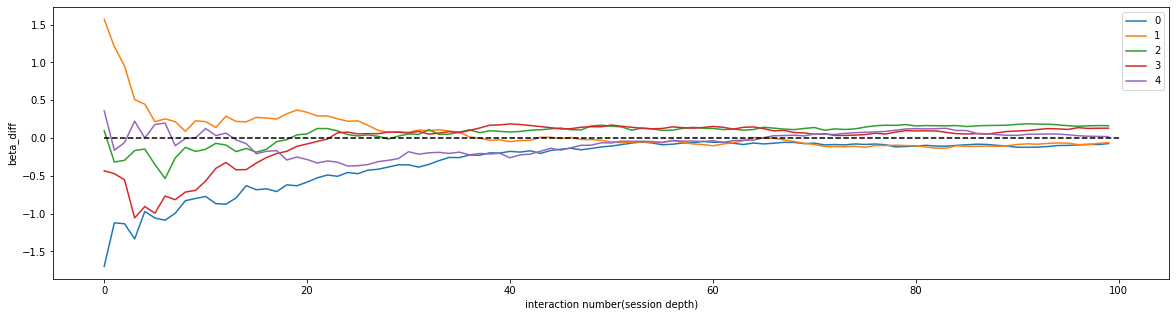

In [132]:
# 对beta进行分析：
# beta_diff 在不同时刻的变化plot: win=1
plt.figure(figsize=(20,diff_level))
ax = plt.subplot()
plots = []
Mean = []
for i in range(0,diff_level):
#     if i not in [1,3,diff_level]:
#         continue
#     k = diff_level-i
    #beta[feature_num-3+diff_level+i,:100]
    plots.append(ax.plot(beta[feature_num-3+diff_level+i,:100].cumsum()/np.arange(1,101)))
    Mean.append(beta[feature_num-3+diff_level+i,:100].mean())

#labels = ["[0.6,1)","[-0.2,0.2)","(-1,-0.6]"]
labels = np.arange(0,diff_level)
plt.legend(plots,labels=labels)
ax.plot([0,100],[0,0],"--k")
ax.set_xlabel("interaction number(session depth)")
ax.set_ylabel("beta_diff")
Mean

In [139]:
beta = (model.net.beta.cpu().detach().numpy())

In [177]:
Min,Max

(array([-3.6965058], dtype=float32), array([3.1261494], dtype=float32))

/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  app.launch_new_instance()


[-0.20875883, -0.14382862, -0.024639804, -0.06502042, -0.03246824]

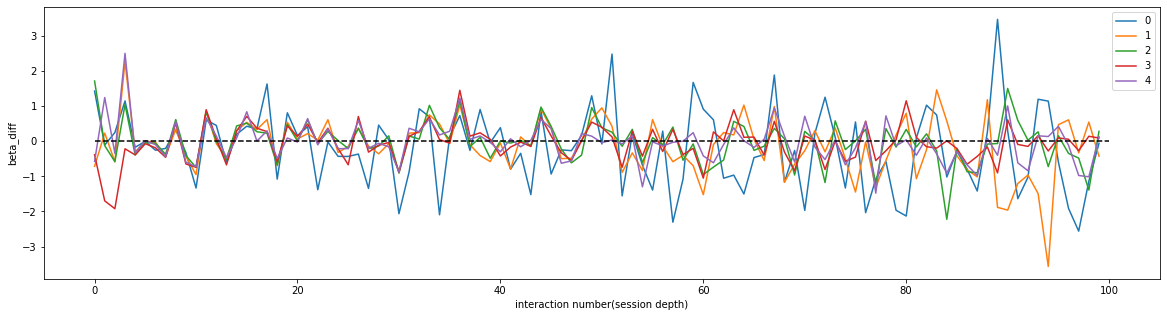

In [142]:
# 对beta进行分析：
# beta_diff 在不同时刻的变化plot: win=0
# 不对alpha和gamma范围进行限制
plt.figure(figsize=(20,diff_level))
ax = plt.subplot()
plots = []
Mean = []
for i in range(0,diff_level):
    #plots.append(ax.plot(beta[feature_num-3+i,:100].cumsum()/np.arange(1,101)))
    plots.append(ax.plot(beta[feature_num-3+i,:100]))
    Mean.append(beta[feature_num-3+i,:100].mean())


#labels = ["[0.6,1)","[-0.2,0.2)","(-1,-0.6]"]
labels = np.arange(0,diff_level)
plt.legend(plots,labels=labels)
ax.plot([0,100],[0,0],"--k")
ax.set_xlabel("interaction number(session depth)")
ax.set_ylabel("beta_diff")
Mean

/work/lijiayu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  from ipykernel import kernelapp as app


[-0.12189187, -0.028407639, 0.1672031, 0.1304059, 0.018258877]

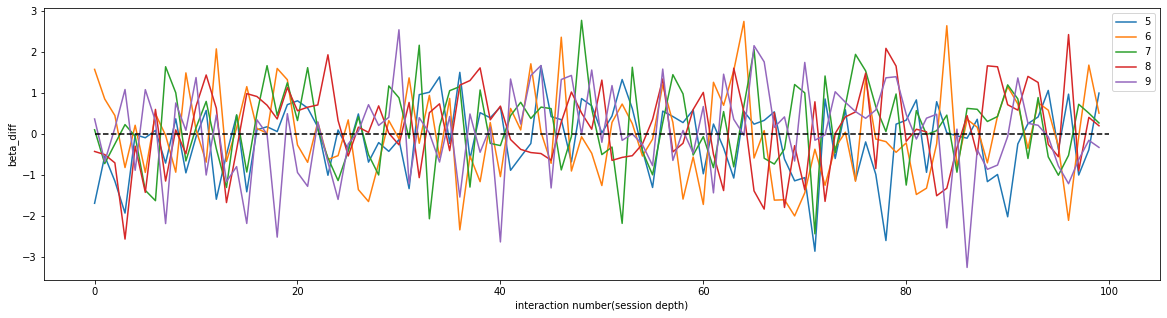

In [147]:
# 对beta进行分析：
# beta_diff 在不同时刻的变化plot: win=1
# 不对alpha和gamma范围进行限制
plt.figure(figsize=(20,diff_level))
ax = plt.subplot()
plots = []
Mean = []
for i in range(0,diff_level):
    #plots.append(ax.plot(beta[feature_num-3+diff_level+i,:100].cumsum()/np.arange(1,101)))
    plots.append(ax.plot(beta[feature_num-3+diff_level+i,:100]))
    Mean.append(beta[feature_num-3+diff_level+i,:100].mean())

#labels = ["[0.6,1)","[-0.2,0.2)","(-1,-0.6]"]
labels = np.arange(diff_level,2*diff_level)
plt.legend(plots,labels=labels)
ax.plot([0,100],[0,0],"--k")
ax.set_xlabel("interaction number(session depth)")
ax.set_ylabel("beta_diff")
Mean

In [59]:
beta[-5:,:].argmin(axis=0)

array([0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 1, 3, 0, 1, 0, 3, 4,
       1, 3, 2, 4, 3, 2, 4, 2, 1, 3, 4, 3, 2, 0, 4, 0, 2, 2, 4, 3, 3, 3,
       3, 3, 1, 1, 0, 4, 3, 3, 3, 4, 4, 0, 3, 2, 1, 3, 3, 3, 3, 2, 3, 3,
       3, 0, 4, 2, 4, 2, 3, 1, 1, 3, 3, 2, 3, 2, 4, 1, 2, 3, 2, 2, 0, 3,
       3, 2, 3, 2, 2, 2, 1, 2, 4, 3, 3, 2, 2, 2, 4, 2, 2, 3, 3, 2, 2, 3,
       2, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 3, 2,
       2, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 2, 2, 3, 2, 3, 2, 2, 1, 3, 3, 3,
       2, 2, 4, 2, 4, 1])

------
## 计算MSE loss

In [48]:
surv_df.shape

(160, 12411)

In [49]:
def h(t,x,uid):
    g_x = model.net.predict(x,uid)
    h_t = baseline_hazards.iloc[t]*np.exp(g_x)
    return h_t

In [50]:
def E(X,uid):
    # x: length*feature*length
    h_list = np.zeros(max_length)
    for t in range(max_length):
        h_list[t] = h(t,X[t,:,:],uid)
    S_list = [np.exp(-np.cumsum(h_list[:t])) for t in range(max_length)]
    E_k = [t*h_list[t]*S_list[t] for t in range(max_length)]
    
    return sum(E_k)

In [ ]:
for x,y in zip(x_train,y_train):
    (E(x,uid)-y)**2

-----
## Example in documentation

### Dataset

In [76]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

### Feature transforms

In [77]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [373]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [374]:
x_train

array([[-1.1060234 ,  3.3136647 , -0.3857527 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.35232577,  0.54783857,  1.2666992 , ...,  1.        ,
         0.        ,  1.        ],
       [-0.7036777 , -0.53397244, -0.67163885, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-0.08655925, -0.90103173,  2.6131732 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.71274495, -0.8366332 ,  0.6886321 , ...,  0.        ,
         0.        ,  1.        ],
       [-0.5830995 , -0.7607197 , -0.7744629 , ...,  1.        ,
         0.        ,  0.        ]], dtype=float32)

In [78]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)

/work/lijiayu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass copy=True, with_mean=True, with_std=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [79]:
y_train[0].shape,y_train[1].shape

((1218,), (1218,))

In [7]:
val.shapes()

((305, 9), ((305,), (305,)))

In [376]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)

In [379]:
help(net.forward)

Help on method forward in module pycox.models.cox_time:

forward(input, time) method of pycox.models.cox_time.MLPVanillaCoxTime instance
    Defines the computation performed at every call.
    
    Should be overridden by all subclasses.
    
    .. note::
        Although the recipe for forward pass needs to be defined within
        this function, one should call the :class:`Module` instance afterwards
        instead of this since the former takes care of running the
        registered hooks while the latter silently ignores them.



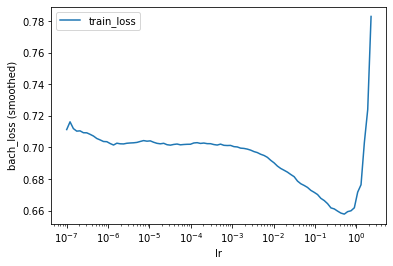

In [161]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [162]:
lrfinder.get_best_lr()

0.050941380148164093

In [163]:
model.optimizer.set_lr(0.01)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [164]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())


0:	[0s / 0s],		train_loss: 0.6869,	val_loss: 0.6731
1:	[0s / 0s],		train_loss: 0.6478,	val_loss: 0.6557
2:	[0s / 0s],		train_loss: 0.6318,	val_loss: 0.6366
3:	[0s / 0s],		train_loss: 0.6262,	val_loss: 0.6301
4:	[0s / 0s],		train_loss: 0.5963,	val_loss: 0.6129
5:	[0s / 0s],		train_loss: 0.5942,	val_loss: 0.6120
6:	[0s / 0s],		train_loss: 0.5982,	val_loss: 0.6115
7:	[0s / 1s],		train_loss: 0.5936,	val_loss: 0.6001
8:	[0s / 1s],		train_loss: 0.5762,	val_loss: 0.5858
9:	[0s / 1s],		train_loss: 0.5849,	val_loss: 0.6056
10:	[0s / 1s],		train_loss: 0.6085,	val_loss: 0.6052
11:	[0s / 1s],		train_loss: 0.5891,	val_loss: 0.6104
12:	[0s / 1s],		train_loss: 0.5860,	val_loss: 0.6095
13:	[0s / 1s],		train_loss: 0.5837,	val_loss: 0.6077
14:	[0s / 1s],		train_loss: 0.5901,	val_loss: 0.6071
15:	[0s / 1s],		train_loss: 0.5896,	val_loss: 0.6090
16:	[0s / 1s],		train_loss: 0.5818,	val_loss: 0.5916
17:	[0s / 1s],		train_loss: 0.5661,	val_loss: 0.5925
18:	[0s / 2s],		train_loss: 0.5657,	val_loss: 0.6010
CPU

----

## 生成random的测试数据

In [34]:
train_sample = 1000
x_input = torch.zeros((train_sample,20,100))# 10000 samples * 20 features * 100 length
for i in range(train_sample):
    a = torch.randint(100,[1]).item()
    x_input[i,:,a] = torch.randn(20)
uid = torch.zeros((train_sample,30)) # 10000 samples, 30 users
for i in range(train_sample):
    a = torch.randint(30,[1]).item()
    uid[i,a] = 1

In [35]:
x_train_rand = (x_input, uid)
#y_train_rand = (torch.randint(100,[train_sample]), torch.ones((train_sample)))
#y_train_rand = (torch.ones((10000))*80,torch.ones((10000)))
y_train_rand = (np.random.randint(100,size=train_sample),np.ones(train_sample))

In [36]:
uid.shape

torch.Size([1000, 30])

In [6]:
val_sample = 100
x_input_val =  torch.zeros((val_sample,20,100))# 1000 samples * 20 features * 100 length
for i in range(val_sample):
    a = torch.randint(100,[1]).item()
    x_input_val[i,:,a] = torch.randn(20)
uid_val = torch.zeros((val_sample,30))
for i in range(val_sample):
    a = torch.randint(30,[1]).item()
    uid_val[i,a] = 1

In [7]:
x_val_rand = (x_input_val, uid_val)
#y_val_rand = (torch.ones((1000))*80, torch.ones((1000)))
#y_val_rand = (torch.randint(100,[val_sample]), torch.ones((val_sample)))
y_val_rand = (np.random.randint(100,size=val_sample),np.ones(val_sample))

In [8]:
x_input.shape,uid.shape

(torch.Size([1000, 20, 100]), torch.Size([1000, 30]))

## 已废弃的模型定义

In [3]:
# class DiffNet(nn.Module):
#     def __init__(self, feature_num, user_num, length, skill_dim=-1, challenge_dim=-2, diff_level=5,device="cpu"):
#         super().__init__()
#         beta = torch.randn((feature_num-2+diff_level, length))
#         self.beta = nn.Parameter(beta)
#         alpha = torch.rand((user_num,1))
#         self.alpha = nn.Parameter(alpha)
#         self.skill_dim = skill_dim
#         self.challenge_dim = challenge_dim
#         self.diff_level = diff_level
#         self.feature_num = feature_num
#         self.user_num = user_num
#         self.length = length
#         self.device = device
    
#     def forward(self, x_input, uid, all_zero=0):
#         u_alpha = torch.mm(uid, torch.clamp(self.alpha.abs(),0,1)).sum(dim=1) # uid: batch_size*user_num, u_alpha: batch_size*1
#         # x_input: batch_size * feature_num * length
#         x_diff = (x_input[:,self.challenge_dim,:]-torch.mul(x_input[:,self.skill_dim,:],u_alpha.unsqueeze(1))) # x_diff: batch_size*length
        
#         level_diff = self.calculate_diff(x_diff)
        
#         feature_idx = [i for i in range(feature_num) if 
#                        i not in [self.skill_dim,self.challenge_dim] and i-feature_num not in [self.skill_dim,self.challenge_dim]]
#         x_input_diff = torch.cat((x_input[:,feature_idx,:],level_diff),dim=1)
        
#         y = x_input_diff.mul(self.beta)  # y: batch_size * feature_num * length
#         return torch.sum(y,(1,2)) # y: batch_size *1
    
#     def predict(self, x_input, uid, all_zero=0):
#         return self.forward(x_input, uid,0)
    
#     def one_hot(self, label):
#         batch_size = label.shape[0]
#         label = label.resize_(batch_size, 1)
#         if self.device=='cpu':
#             m_zeros = torch.zeros(batch_size, self.diff_level+1)
#         else:
#             m_zeros = torch.zeros(batch_size, self.diff_level+1).cuda()
#         onehot = m_zeros.scatter_(1, label, 1)[:,:-1]  # (dim,index,value)

#         return onehot  # Tensor -> Numpy
    
#     def calculate_diff(self, x):
#         # x: batch_size*length
#         #x_level = self.one_hot((x_diff.max(dim=1)[0]*self.diff_level).floor().long())# batch_size * diff_level
        
#         #level_diff = torch.mul((x_diff*self.diff_level).frac().unsqueeze(1).repeat(1,self.diff_level,1),x_level.unsqueeze(2).repeat(1,1,self.length))# batch_size * diff_level * length
#         #level_diff = torch.mul(x_diff.unsqueeze(1).repeat(1,self.diff_level,1),x_level.unsqueeze(2).repeat(1,1,self.length))# batch_size * diff_level * length
        
#         x_level = self.one_hot(((x.sum(dim=1)+1)/2*self.diff_level).floor().long()) # x_level: batch_size * diff_level
#         level_diff = torch.mul((x!=0).float().unsqueeze(1).repeat(1,self.diff_level,1),x_level.unsqueeze(2).repeat(1,1,self.length))# batch_size * diff_level * length
        
#         return level_diff
#         # return: batch_size* diff_level * length

In [77]:
# # difficulty 不分情况
# class DiffNet(nn.Module):
#     def __init__(self, feature_num, user_num, length, skill_dim=-1, challenge_dim=-2, diff_level=5,device="cpu"):
#         super().__init__()
#         beta = torch.randn((feature_num-2+diff_level, length))
#         self.beta = nn.Parameter(beta)
#         alpha = torch.rand((user_num,1))
#         self.alpha = nn.Parameter(alpha)
#         self.skill_dim = skill_dim
#         self.challenge_dim = challenge_dim
#         self.diff_level = diff_level
#         self.feature_num = feature_num
#         self.user_num = user_num
#         self.length = length
#         self.device = device
    
#     def forward(self, x_input, uid, t):
#         # x_input: batch_size * feature_num * length
#         # uid: batch_size * user_num
#         u_alpha = torch.mm(uid, torch.clamp(self.alpha.abs(),0,1)).sum(dim=1) # u_alpha: batch_size*1
#         x_diff = (x_input[:,self.challenge_dim,:]-torch.mul(x_input[:,self.skill_dim,:],u_alpha.unsqueeze(1))) # x_diff: batch_size*length
        
#         level_diff = self.calculate_diff(x_diff)
        
#         feature_idx = [i for i in range(feature_num) if 
#                        i not in [self.skill_dim,self.challenge_dim] and i-feature_num not in [self.skill_dim,self.challenge_dim]]
#         x_input_diff = torch.cat((x_input[:,feature_idx,:],level_diff),dim=1) # batch_size*feature*length
        
#         y = self.time_mul(x_input_diff,t)  # y: batch_size * 1
#         return y # y: batch_size *1
    
#     def time_mul(self, x_input, t):
#         # x_input: batch_size * feature * length
#         # t: batch_size * 1
#         batch_size = x_input.shape[0]
#         #t = t.long().detach().cpu().numpy()-1

#         #y = []
#         #for i in range(batch_size):
#         #    y.append((x_input[i,:,t[i]]*self.beta[:,t[i]]).sum())
        
#         x_beta = (x_input*self.beta).sum(dim=1) # batch_size*length
#         #y = x_beta[np.arange(batch_size),t.long()-1]
#         y = torch.gather(x_beta,dim=1,index=t.long()-1)#.unsqueeze(1)
        
#         #return torch.stack(y)
#         return y
    
#     def predict(self, x_input, uid, t):
#         return self.forward(x_input, uid, t)
    
#     def one_hot(self, label):
#         batch_size = label.shape[0]
#         length = label.shape[1]
#         label = label.resize_(batch_size, 1, length)
#         if self.device=='cpu':
#             m_zeros = torch.zeros(batch_size,  self.diff_level+1, length)
#         else:
#             m_zeros = torch.zeros(batch_size,  self.diff_level+1, length).cuda()
#         onehot = m_zeros.scatter_(1, label, 1)[:,:-1]  # (dim,index,value)
        
#         return onehot  # Tensor -> Numpy
    
#     def calculate_diff(self, x):
#         # x: batch_size*length
        
#         x_level = self.one_hot(((x+1)/2*self.diff_level).floor().long()) # x_level: batch_size * diff_level * length
        
#         return x_level  #batch_size* diff_level * length